**Table of contents**<a id='toc0_'></a>    
- [SemEval 2023 Task 10 Subtask A -- Baseline](#toc1_)    
  - [Loading the data](#toc1_1_)    
  - [Tokenize](#toc1_2_)    
  - [Train](#toc1_3_)    
  - [Sharing and Reusing Model](#toc1_4_)    
  - [Development Data](#toc1_5_)    
  - [Ideas for improvement](#toc1_6_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[SemEval 2023 Task 10 Subtask A -- Baseline](#toc0_)

Dieses Notebook fine-tuned DistilBert mit den Trainingsdaten. Dieses Modell dient dann als Ausgangs- und Vergleichspunkt für spätere Modelle

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install transformers
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 32.4 MB/s 
     |████████████████████████████████| 7.6 MB 56.3 MB/s 
     |████████████████████████████████| 182 kB 76.5 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 451 kB 30.3 MB/s 
     |████████████████████████████████| 212 kB 74.3 MB/s 
     |████████████████████████████████| 132 kB 65.3 MB/s 
     |████████████████████████████████| 127 kB 46.1 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


## <a id='toc1_1_'></a>[Loading the data](#toc0_)

In [3]:
import sys
import urllib
import datasets
import matplotlib.pyplot as plt
import torch
import transformers
import numpy as np
import pandas as pd


In [4]:
from datasets import load_dataset

path = 'drive/MyDrive/data/Semeval23Task10/train_all_tasks.csv'
#path = "./data/Semeval23Task10/train_all_tasks.csv"
# to read a file from github: open data as view raw and copy url
#path = "https://raw.githubusercontent.com/WiebkePetersen/TransformerTeaching/main/data/Semeval23Task10/train_all_tasks.csv?token=GHSAT0AAAAAABYT5WRQGCY367RQO5Q3P6XQY4AWKRA" 
ds = load_dataset("csv", 
                  data_files=path)  # data_files is either an url or a path to a local file 


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-a222cced2b624fba/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [5]:
ds

DatasetDict({
    train: Dataset({
        features: ['rewire_id', 'text', 'label_sexist', 'label_category', 'label_vector'],
        num_rows: 14000
    })
})

In [6]:
ds["train"].features

{'rewire_id': Value(dtype='string', id=None),
 'text': Value(dtype='string', id=None),
 'label_sexist': Value(dtype='string', id=None),
 'label_category': Value(dtype='string', id=None),
 'label_vector': Value(dtype='string', id=None)}

The features must be adapted and class labels must be added:

In [7]:
ds = ds.class_encode_column("label_sexist")

Casting to class labels:   0%|          | 0/14 [00:00<?, ?ba/s]

In [8]:
ds["train"]["label_sexist"][:10]

[0, 0, 0, 0, 0, 0, 0, 0, 1, 0]

In [9]:
print(ds["train"].features)
print(ds["train"][0])

{'rewire_id': Value(dtype='string', id=None), 'text': Value(dtype='string', id=None), 'label_sexist': ClassLabel(names=['not sexist', 'sexist'], id=None), 'label_category': Value(dtype='string', id=None), 'label_vector': Value(dtype='string', id=None)}
{'rewire_id': 'sexism2022_english-7358', 'text': 'Damn, this writing was pretty chaotic', 'label_sexist': 0, 'label_category': 'none', 'label_vector': 'none'}


In [10]:
ds.set_format(type="pandas")  # set_format only changes output style
df = ds["train"][:]
df.head()

,rewire_id,text,label_sexist,label_category,label_vector
0,sexism2022_english-7358,"Damn, this writing was pretty chaotic",0,none,none
1,sexism2022_english-2367,"Yeah, and apparently a bunch of misogynistic v...",0,none,none
2,sexism2022_english-3073,How the FUCK is this woman still an MP!!!???,0,none,none
3,sexism2022_english-14895,Understand. Know you're right. At same time I ...,0,none,none
4,sexism2022_english-4118,Surprized they didn't stop and rape some women,0,none,none


In [11]:
def label_int2str(row):
    return ds["train"].features["label_sexist"].int2str(row)

df["label_name"] = df["label_sexist"].apply(label_int2str)
df.head()

,rewire_id,text,label_sexist,label_category,label_vector,label_name
0,sexism2022_english-7358,"Damn, this writing was pretty chaotic",0,none,none,not sexist
1,sexism2022_english-2367,"Yeah, and apparently a bunch of misogynistic v...",0,none,none,not sexist
2,sexism2022_english-3073,How the FUCK is this woman still an MP!!!???,0,none,none,not sexist
3,sexism2022_english-14895,Understand. Know you're right. At same time I ...,0,none,none,not sexist
4,sexism2022_english-4118,Surprized they didn't stop and rape some women,0,none,none,not sexist


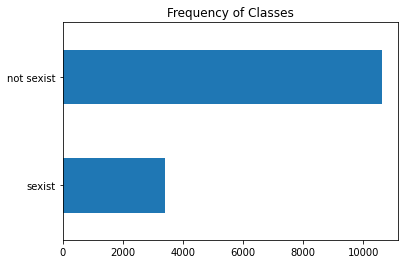

In [12]:
import matplotlib.pyplot as plt

df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

In [13]:
count_label0, count_label1 = df["label_name"].value_counts()
count_label0, count_label1

(10602, 3398)

/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


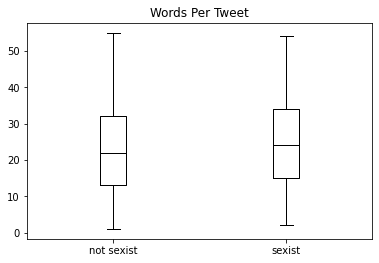

In [14]:
df["Words Per Tweet"] = df["text"].str.split().apply(len)
df.boxplot("Words Per Tweet", by="label_name", grid=False,
          showfliers=False, color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()

In [15]:
ds.reset_format() # reset output format

In [16]:
ds =ds.rename_column("label_sexist", "labels")
sexist = ds["train"].train_test_split(shuffle=True,test_size=0.1,seed=42)
sexist


DatasetDict({
    train: Dataset({
        features: ['rewire_id', 'text', 'labels', 'label_category', 'label_vector'],
        num_rows: 12600
    })
    test: Dataset({
        features: ['rewire_id', 'text', 'labels', 'label_category', 'label_vector'],
        num_rows: 1400
    })
})

In [17]:
sexist.save_to_disk("drive/MyDrive/data/Semeval23Task10")

Flattening the indices:   0%|          | 0/13 [00:00<?, ?ba/s]

Flattening the indices:   0%|          | 0/2 [00:00<?, ?ba/s]

## <a id='toc1_2_'></a>[Tokenize](#toc0_)

In [18]:
from transformers import AutoTokenizer

checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [19]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

In [20]:
sexist_tokenized = sexist.map(tokenize, batched=True, batch_size=1000)


  0%|          | 0/13 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

In [21]:
sexist_tokenized["train"].column_names

['rewire_id',
 'text',
 'labels',
 'label_category',
 'label_vector',
 'input_ids',
 'attention_mask']

## <a id='toc1_3_'></a>[Train](#toc0_)

HuggingFace allows users with an account to save their models on the HuggingFace hub in order to publish their models and reuse them. In order to do so, we need to log in to the Hub (if you do not want to create an account, just comment out all lines and cells marked by `# HuggingFace account necessary`):

In [26]:
# HuggingFace account necessary
from huggingface_hub import notebook_login

hugging = True

if hugging == True:
    notebook_login()

# if working from a terminal use $ huggingface-cli login

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.huggingface/token
Login successful


In [27]:
from transformers import AutoModelForSequenceClassification

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = (AutoModelForSequenceClassification
         .from_pretrained(checkpoint, num_labels=2)
         .to(device))

To train the model we use the `Trainer` API from Transformers.

In order to do so, we first have to define a **performance metrics** that evaluates the performance of our model during training. Our `compute_metrics` function expects an `EvalPrediction object` that is a pair of a prediction and a label. The function returns the [F1 (harmonic mean of precision and recall)](https://en.wikipedia.org/wiki/F-score) and the accuracy score as a dictionary. Here, the F1-score is computed by weighting the F1-scores of the individual labels by their support, i.e. the number of true instances for each label. See [here](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html) for details on alternative F1-score calculation methods. 

In [28]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

Additionally we have to set the `TrainingArguments` for the `Trainer`:

In [29]:
from transformers import Trainer, TrainingArguments

batch_size = 64
logging_steps = len(sexist_tokenized["train"]) // batch_size
model_path = f"{checkpoint}-sexist_baseline"
training_args = TrainingArguments(output_dir=model_path,
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  evaluation_strategy="steps",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=hugging, # HuggingFace account necessary
                                  log_level="error")

trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=sexist_tokenized["train"],
                  eval_dataset=sexist_tokenized["test"],
                  tokenizer=tokenizer)

Cloning https://huggingface.co/Wiebke/distilbert-base-uncased-sexist_baseline into local empty directory.


Download file pytorch_model.bin:   0%|          | 3.43k/255M [00:00<?, ?B/s]

Download file training_args.bin: 100%|##########| 3.37k/3.37k [00:00<?, ?B/s]

Download file runs/Dec18_17-09-34_92a3fff92f45/1671383384.1241064/events.out.tfevents.1671383384.92a3fff92f45.…

Download file runs/Dec18_17-09-34_92a3fff92f45/events.out.tfevents.1671383384.92a3fff92f45.76.0:  42%|####1   …

Clean file training_args.bin:  30%|##9       | 1.00k/3.37k [00:00<?, ?B/s]

Clean file runs/Dec18_17-09-34_92a3fff92f45/1671383384.1241064/events.out.tfevents.1671383384.92a3fff92f45.76.…

Clean file runs/Dec18_17-09-34_92a3fff92f45/events.out.tfevents.1671383384.92a3fff92f45.76.0:  20%|##        |…

Clean file pytorch_model.bin:   0%|          | 1.00k/255M [00:00<?, ?B/s]

In [30]:
sexist_tokenized["train"].features

{'rewire_id': Value(dtype='string', id=None),
 'text': Value(dtype='string', id=None),
 'labels': ClassLabel(names=['not sexist', 'sexist'], id=None),
 'label_category': Value(dtype='string', id=None),
 'label_vector': Value(dtype='string', id=None),
 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None),
 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None)}

Now we can fine-tune our model:

In [31]:
trainer.train()

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy,F1
196,0.428700,0.337940,0.860000,0.856312
392,0.300400,0.324599,0.857857,0.856592


TrainOutput(global_step=394, training_loss=0.3642050658688327, metrics={'train_runtime': 206.1791, 'train_samples_per_second': 122.224, 'train_steps_per_second': 1.911, 'total_flos': 606315702467136.0, 'train_loss': 0.3642050658688327, 'epoch': 2.0})

With the `.predict()` method of `Trainer`we can use our now trained model to make predictions

In [32]:
preds_output = trainer.predict(sexist_tokenized["test"])

In [33]:
preds_output

PredictionOutput(predictions=array([[ 0.0891031 , -0.19094297],
       [ 0.895234  , -0.9377574 ],
       [ 1.761144  , -1.9668477 ],
       ...,
       [ 0.15485774, -0.19739379],
       [ 1.8777708 , -2.1559827 ],
       [-0.58227676,  0.6319072 ]], dtype=float32), label_ids=array([1, 0, 0, ..., 1, 0, 1]), metrics={'test_loss': 0.3246082067489624, 'test_accuracy': 0.8571428571428571, 'test_f1': 0.8559414626919569, 'test_runtime': 3.8927, 'test_samples_per_second': 359.647, 'test_steps_per_second': 5.652})

In [34]:
preds_output.metrics

{'test_loss': 0.3246082067489624,
 'test_accuracy': 0.8571428571428571,
 'test_f1': 0.8559414626919569,
 'test_runtime': 3.8927,
 'test_samples_per_second': 359.647,
 'test_steps_per_second': 5.652}

`.predict()` also returns an array of the raw predictions (`.predictions`), i.e. the softmax values for the class labels. We transform them into predicted labels by `np.argmax()`

In [35]:
y_preds = np.argmax(preds_output.predictions, axis=1)
y_test = np.array(sexist_tokenized["test"]["labels"])

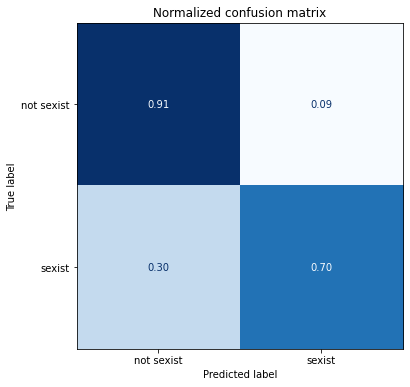

In [36]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()
    

labels = sexist_tokenized["test"].features["labels"].names
plot_confusion_matrix(y_preds, y_test, labels)

In [37]:
from sklearn.metrics import confusion_matrix, classification_report

print(classification_report(y_test,y_preds))

              precision    recall  f1-score   support

           0       0.90      0.91      0.90      1037
           1       0.74      0.70      0.72       363

    accuracy                           0.86      1400
   macro avg       0.82      0.81      0.81      1400
weighted avg       0.86      0.86      0.86      1400



## <a id='toc1_4_'></a>[Sharing and Reusing Model](#toc0_)

In [38]:
# HuggingFace account necessary

trainer.push_to_hub(commit_message="Training completed!") 


Upload file runs/Dec18_18-53-53_b960101032c8/1671389747.4629467/events.out.tfevents.1671389747.b960101032c8.74…

Upload file runs/Dec18_18-53-53_b960101032c8/events.out.tfevents.1671389747.b960101032c8.74.0:  67%|######6   …

Upload file training_args.bin:  98%|#########7| 3.30k/3.37k [00:00<?, ?B/s]

remote: Scanning LFS files for validity, may be slow...        
remote: LFS file scan complete.        
To https://huggingface.co/Wiebke/distilbert-base-uncased-sexist_baseline
   7f1bd79..724c06f  main -> main

remote: LFS file scan complete.        
To https://huggingface.co/Wiebke/distilbert-base-uncased-sexist_baseline
   7f1bd79..724c06f  main -> main



'https://huggingface.co/Wiebke/distilbert-base-uncased-sexist_baseline/commit/724c06f7392c5778d6ed2bd46d7cdcefd6675151'

In [40]:
from transformers import pipeline

# Change `Wiebke` to your Hub username
model_id = "Wiebke/distilbert-base-uncased-sexist_baseline"
classifier = pipeline("text-classification", model=model_id)

Downloading:   0%|          | 0.00/615 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/360 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/712k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [41]:
text = ["She is a bitch!", "I like chocolate."]
test_class = classifier(text, return_all_scores=True, function_to_apply="softmax")
test_class

/usr/local/lib/python3.8/dist-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar funcionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


[[{'label': 'LABEL_0', 'score': 0.038594555109739304},
  {'label': 'LABEL_1', 'score': 0.9614054560661316}],
 [{'label': 'LABEL_0', 'score': 0.974768340587616},
  {'label': 'LABEL_1', 'score': 0.025231657549738884}]]

In [44]:
from datasets import load_from_disk
model_id = "Wiebke/distilbert-base-uncased-sexist_baseline"
mydata = load_from_disk("drive/MyDrive/data/Semeval23Task10")


In [45]:
mymodel = AutoModelForSequenceClassification.from_pretrained(model_id, use_auth_token=True)
mytokenizer = AutoTokenizer.from_pretrained(model_id, use_auth_token=True)
mytrainingarguments = TrainingArguments(model_id)
mytrainer = Trainer(model=mymodel,tokenizer=mytokenizer,args=mytrainingarguments)

In [46]:
def mytokenize(batch):
    return mytokenizer(batch["text"], padding=True, truncation=True)

In [47]:
test_tokenized = mydata["test"].map(mytokenize, batched=True, batch_size=1000)

In [48]:
test_tokenized

Dataset({
    features: ['rewire_id', 'text', 'labels', 'label_category', 'label_vector', 'input_ids', 'attention_mask'],
    num_rows: 1400
})

In [49]:
mypred = mytrainer.predict(test_tokenized)
mypred

The following columns in the test set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: rewire_id, label_vector, label_category, text. If rewire_id, label_vector, label_category, text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 1400
  Batch size = 8
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


PredictionOutput(predictions=array([[ 0.08910333, -0.19094318],
       [ 0.8952338 , -0.93775713],
       [ 1.761144  , -1.9668478 ],
       ...,
       [ 0.1548571 , -0.19739299],
       [ 1.8777709 , -2.155983  ],
       [-0.58227646,  0.63190705]], dtype=float32), label_ids=array([1, 0, 0, ..., 1, 0, 1]), metrics={'test_loss': 0.3246082067489624, 'test_runtime': 3.9619, 'test_samples_per_second': 353.363, 'test_steps_per_second': 44.17})

In [50]:
import scipy as sc
y_preds = sc.special.softmax(mypred.predictions, axis=1)
y_preds

array([[0.5695576 , 0.43044236],
       [0.86211765, 0.13788235],
       [0.97652334, 0.02347666],
       ...,
       [0.5871631 , 0.41283685],
       [0.9826004 , 0.01739962],
       [0.22896165, 0.7710383 ]], dtype=float32)

In [52]:
probs_sexist = [sm[1] for sm in y_preds]
mydata.set_format(type="pandas")
df = mydata["test"][:]
df["probs_sexist"] = probs_sexist
df.to_csv("testdata_predict.csv")
mydata.reset_format()
df.head()

,rewire_id,text,labels,label_category,label_vector,probs_sexist
0,sexism2022_english-1422,"Stupid white woman, liberal mind set is screwe...",1,2. derogation,2.2 aggressive and emotive attacks,0.430442
1,sexism2022_english-12593,"""Baby's in the cradle, Brother's on the town. ...",0,none,none,0.137882
2,sexism2022_english-17802,#VoteDemOut seditionist wanna be socialists ne...,0,none,none,0.023477
3,sexism2022_english-13656,"Naked outdoors topic, star to fav ))) [URL]",0,none,none,0.017571
4,sexism2022_english-9777,I will probably try to date both of the girls ...,0,none,none,0.154420


## <a id='toc1_5_'></a>[Development Data](#toc0_)

We should use all avaiable data for training, i.e. no split in test and train. Therefore we train once more on the test data

In [ ]:
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
#                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=False, 
                                  log_level="error")

trainer = Trainer(model=model, args=training_args,
                  train_dataset= sexist_tokenized["test"],
                  tokenizer=tokenizer)

In [ ]:
trainer.train()

In [ ]:
path = "drive/MyDrive/data/Semeval23Task10/dev_task_a_entries.csv" 
dev_data = load_dataset("csv", 
                  data_files=path)  # data_files is either an url or a path to a local file 




In [ ]:
dev_data

In [ ]:
dev_tokenized = dev_data.map(tokenize, batched=True, batch_size=1000)

In [ ]:
dev_pred = trainer.predict(dev_tokenized["train"])

In [ ]:
dev_pred

In [ ]:
y_preds = np.argmax(dev_pred.predictions, axis=1)

In [ ]:
y_preds

In [ ]:
dev_data.set_format(type="pandas")
df = dev_data["train"][:]
df["y_preds"] = y_preds
df.head()

In [ ]:
sexist_tokenized["train"].features

In [ ]:
df.head()

In [ ]:
def label_int2str(row):
    return sexist_tokenized["train"].features["labels"].int2str(row)

df["label_pred"] = df["y_preds"].apply(label_int2str)
df = df.drop(["text","y_preds"], axis=1)
df.head()

In [ ]:
compression_opts = dict(method='zip',
                        archive_name='out.csv')  
df.to_csv('out.zip', compression=compression_opts)

## <a id='toc1_6_'></a>[Ideas for improvement](#toc0_)



*   use additional provided data and use only those with a very high softmax as additional training data [in Notebook TaskSexSemeval_2_semi-supervised_second_try]
*   look for techniques for imbalanced data 
<= over- and undersampling no improvement [in Notebook TaskSexSemeval_1_imbalanced_data]
*   try other models [machen]
*   look for a pretrained model on hate speech detection [machen]
*   increase epochs? [machen]
*   use simple ML-techniques on the tweets represented by idf-vectors [in Notebook TaskSexSemeval_3_idf]
*   test a simple mask model? [in Notebook TaskSexSemeval_4_zeroshot nicht erfolgreich]


